# COMP41680 Assignment 2 - Part_2
Name: Shuhao Guan  
ID: 20211120

Preprocess the data, and evaluate the performance of different classifiers in the context of two related text classification tasks:
- (i) predicting review sentiment; 
- (ii) predicting review helpfulness.

Import the library.

In [1]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn import svm,naive_bayes
import sklearn
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from numpy import *
import numpy as np
import matplotlib.pyplot as plt

Read the csv file

In [2]:
import pandas as pd
df = pd.read_csv("./merged_data/review.csv")

Remove the stop word and make all words lowercase.

In [3]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
df['word_new']=df.apply(lambda x:" ".join([word for word in (x[1]+' '+x[2]).split() if word.lower() not in ENGLISH_STOP_WORDS]).lower(), axis=1)

In [4]:
df.head()

,star,title,review,helpful1,helpful2,word_new
0,2,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,15,17,herbs great...but cherry tomatoes...not great ...
1,5,Even more useful than regular parchment paper,I originally bought this just because it was c...,19,19,useful regular parchment paper originally boug...
2,2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,13,"shake bake reverse (bake shaking), you're goin..."
3,2,Not what the picture describes,I bought this steak for my father in law for C...,7,14,picture describes bought steak father law chri...
4,2,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,10,34,ripe - break sorry noodles better 10 - 20 cent...


**Word_new** column is a merge of titles and reviews with deactivated words removed

## Task 2. Review Sentiment Classification

Add the **sentiment** for the reviews to the dataframe.

In [5]:
df['sentiment']=df.apply(lambda x: 'positive' if x[0]>=3 else 'negative', axis=1)

In [6]:
df.head()

,star,title,review,helpful1,helpful2,word_new,sentiment
0,2,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,15,17,herbs great...but cherry tomatoes...not great ...,negative
1,5,Even more useful than regular parchment paper,I originally bought this just because it was c...,19,19,useful regular parchment paper originally boug...,positive
2,2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,13,"shake bake reverse (bake shaking), you're goin...",negative
3,2,Not what the picture describes,I bought this steak for my father in law for C...,7,14,picture describes bought steak father law chri...,negative
4,2,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,10,34,ripe - break sorry noodles better 10 - 20 cent...,negative


In [7]:
df["sentiment"].value_counts()

positive    5915
negative    3329
Name: sentiment, dtype: int64

### Classifiers with Tfidf features

Extract TFIDF features for our dataset.

In [8]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(use_idf=True,ngram_range=(1,2))
data=vectorizer.fit_transform(df['word_new'])
target=df["sentiment"].values
target=pd.DataFrame(target)[0].factorize()[0]

It can be seen that our data set has become a matrix of 9244x379904.

In [9]:
data

<9244x379904 sparse matrix of type '<class 'numpy.float64'>'
	with 1214029 stored elements in Compressed Sparse Row format>

In [10]:
task2_AUC=[]
task3_AUC=[]

#### Bulid classifiers

Use **train_test_split** to split the train and test set.

In [11]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size = 0.2,stratify = target)

I create three separate classifiers, an SVM classifier, a logistic regression classifier, and an NB classifier. Then I look at their performance on the training set and the test set respectively, and plot the ROC curves.

---------------------On test set--------------------
              precision    recall  f1-score   support

    Negative       0.88      0.77      0.82       666
    Positive       0.88      0.94      0.91      1183

    accuracy                           0.88      1849
   macro avg       0.88      0.85      0.86      1849
weighted avg       0.88      0.88      0.88      1849

[[ 511  155]
 [  68 1115]]
---------------------On train set-------------------
              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00      2663
    Positive       1.00      1.00      1.00      4732

    accuracy                           1.00      7395
   macro avg       1.00      1.00      1.00      7395
weighted avg       1.00      1.00      1.00      7395

[[2663    0]
 [   0 4732]]
-------------------------ROC-----------------------
AUC: 0.95


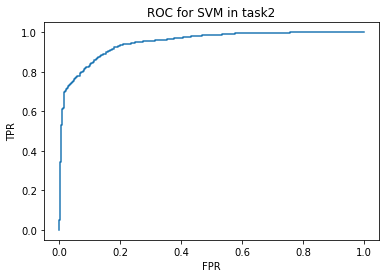

In [12]:
svm_clf = sklearn.svm.LinearSVC()

svm_clf.fit(train_data, train_target)
print("---------------------On test set--------------------")
print(sklearn.metrics.classification_report(test_target, svm_clf.predict(test_data), target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_target, svm_clf.predict(test_data)))
print("---------------------On train set-------------------")
print(sklearn.metrics.classification_report(train_target, svm_clf.predict(train_data), target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(train_target, svm_clf.predict(train_data)))
print("-------------------------ROC-----------------------")
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(test_target,svm_clf.decision_function(test_data))
print ('AUC:', round(metrics.auc(fpr, tpr),3))
task2_AUC.append(round(metrics.auc(fpr, tpr),3))
plt.plot(fpr,tpr,label='ROC')
plt.title("ROC for SVM in task2")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

---------------------On test set--------------------
              precision    recall  f1-score   support

    Negative       0.91      0.62      0.73       666
    Positive       0.82      0.97      0.88      1183

    accuracy                           0.84      1849
   macro avg       0.86      0.79      0.81      1849
weighted avg       0.85      0.84      0.83      1849

[[ 410  256]
 [  41 1142]]
---------------------On train set-------------------
              precision    recall  f1-score   support

    Negative       0.99      0.84      0.91      2663
    Positive       0.92      0.99      0.95      4732

    accuracy                           0.94      7395
   macro avg       0.95      0.92      0.93      7395
weighted avg       0.94      0.94      0.94      7395

[[2245  418]
 [  28 4704]]
-------------------------ROC-----------------------
AUC: 0.933


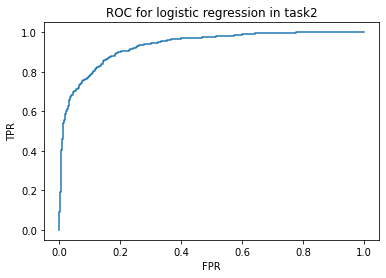

In [13]:
lgre_clf = sklearn.linear_model.LogisticRegression()

lgre_clf.fit(train_data, train_target)
print("---------------------On test set--------------------")
print(sklearn.metrics.classification_report(test_target, lgre_clf.predict(test_data), target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_target, lgre_clf.predict(test_data)))
print("---------------------On train set-------------------")
print(sklearn.metrics.classification_report(train_target, lgre_clf.predict(train_data), target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(train_target, lgre_clf.predict(train_data)))
print("-------------------------ROC-----------------------")
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(test_target,lgre_clf.decision_function(test_data))
print ('AUC:', round(metrics.auc(fpr, tpr),3))
task2_AUC.append(round(metrics.auc(fpr, tpr),3))
plt.title("ROC for logistic regression in task2")
plt.plot(fpr,tpr,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

---------------------On test set--------------------
              precision    recall  f1-score   support

    Negative       0.99      0.22      0.36       666
    Positive       0.69      1.00      0.82      1183

    accuracy                           0.72      1849
   macro avg       0.84      0.61      0.59      1849
weighted avg       0.80      0.72      0.65      1849

[[ 146  520]
 [   2 1181]]
---------------------On train set-------------------
              precision    recall  f1-score   support

    Negative       1.00      0.45      0.63      2663
    Positive       0.77      1.00      0.87      4732

    accuracy                           0.80      7395
   macro avg       0.88      0.73      0.75      7395
weighted avg       0.85      0.80      0.78      7395

[[1211 1452]
 [   0 4732]]
-------------------------ROC-----------------------
AUC: 0.911


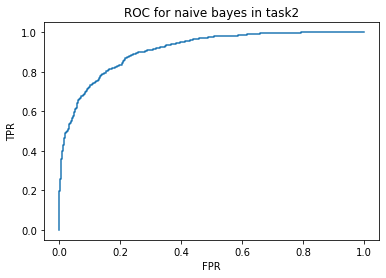

In [14]:
nvb_clf = sklearn.naive_bayes.MultinomialNB()

nvb_clf.fit(train_data, train_target)
print("---------------------On test set--------------------")
print(sklearn.metrics.classification_report(test_target, nvb_clf.predict(test_data), target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(test_target, nvb_clf.predict(test_data)))
print("---------------------On train set-------------------")
print(sklearn.metrics.classification_report(train_target, nvb_clf.predict(train_data), target_names=['Negative', 'Positive']))
print(sklearn.metrics.confusion_matrix(train_target, nvb_clf.predict(train_data)))
print("-------------------------ROC-----------------------")
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(test_target,nvb_clf.predict_proba(test_data)[:,1])
print ('AUC:', round(metrics.auc(fpr, tpr),3))
task2_AUC.append(round(metrics.auc(fpr, tpr),3))
plt.title("ROC for naive bayes in task2")
plt.plot(fpr,tpr,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

We can see that the SVM classifier has the highest AUC value and it has a high accuracy rate.

Use **cross_validate** to validate classifiers. scoring=["accuracy","f1"]

In [15]:
scoring=["accuracy","f1"]
svm_scores = cross_validate(svm_clf, data, target, cv=5,scoring=scoring,return_train_score=True)
svm_time=svm_scores['fit_time'].mean()
svm_test_accuracy=svm_scores['test_accuracy'].mean()
svm_train_accuracy=svm_scores['train_accuracy'].mean()
svm_test_f1=svm_scores['test_f1'].mean()
svm_train_f1=svm_scores['train_f1'].mean()

In [16]:
lgre_scores = cross_validate(lgre_clf, data, target, cv=5,scoring=scoring,return_train_score=True)
lgre_time=lgre_scores['fit_time'].mean()
lgre_test_accuracy=lgre_scores['test_accuracy'].mean()
lgre_train_accuracy=lgre_scores['train_accuracy'].mean()
lgre_test_f1=lgre_scores['test_f1'].mean()
lgre_train_f1=lgre_scores['train_f1'].mean()

In [17]:
nvb_scores = cross_validate(nvb_clf, data, target, cv=5,scoring=scoring,return_train_score=True)
nvb_time=nvb_scores['fit_time'].mean()
nvb_test_accuracy=nvb_scores['test_accuracy'].mean()
nvb_train_accuracy=nvb_scores['train_accuracy'].mean()
nvb_test_f1=nvb_scores['test_f1'].mean()
nvb_train_f1=nvb_scores['train_f1'].mean()

#### Visualisation of classification results

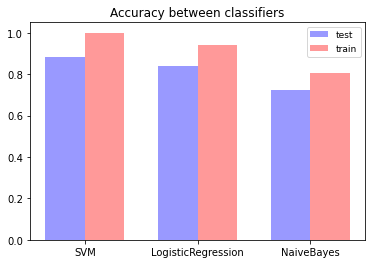

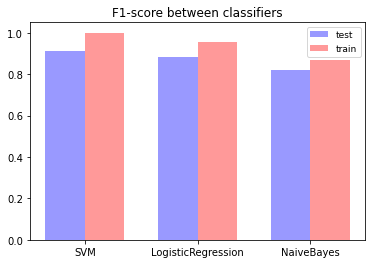

In [18]:
index = np.arange(3)
bar_width = 0.35
y1 = [svm_test_accuracy, lgre_test_accuracy, nvb_test_accuracy]
y2 =[svm_train_accuracy, lgre_train_accuracy, nvb_train_accuracy]
plt.bar(index, y1, bar_width,
                alpha=0.4, color='b',label='test')
plt.bar(index+bar_width, y2, bar_width,
                alpha=0.4, color='r',label='train')
x_labels = ['SVM', 'LogisticRegression', 'NaiveBayes']
plt.xticks(index+bar_width/2, x_labels) 
plt.title("Accuracy between classifiers")
plt.legend(prop={"size": 9})
plt.show()

index = np.arange(3)
bar_width = 0.35
y1 = [svm_test_f1, lgre_test_f1, nvb_test_f1]
y2 =[svm_train_f1, lgre_train_f1, nvb_train_f1]
plt.bar(index, y1, bar_width,
                alpha=0.4, color='b',label='test')
plt.bar(index+bar_width, y2, bar_width,
                alpha=0.4, color='r',label='train')
x_labels = ['SVM', 'LogisticRegression', 'NaiveBayes']
plt.xticks(index+bar_width/2, x_labels) 
plt.title("F1-score between classifiers")
plt.legend(prop={"size": 9})
plt.show()

As you can see the SVM classifier is the best classifier in this problem, achieving almost 100% accuracy in the training set and 88% accuracy in the test set. the naive bayes classifier is the least accurate, but it runs the fastest. The logistic regression classifier also gave good results but took longer.

### LSTM classifier

Use the **factorize()** method to convert categorical values to numerical values.

In [19]:
sentiment_label = df.sentiment.factorize()
word_new = df.word_new.values

With the help of the tokeniser, all words in the text are tokenised. During tokenisation, we break down all words/sentences in the text into small parts called tokens.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(word_new)
vocab_size = len(tokenizer.word_index) + 1

Use the **text_to_sequence()** method to replace the word with its specified number.

In [21]:
word_seq = tokenizer.texts_to_sequences(word_new)

Then we let all sentences have the same length.

In [22]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
word_pad = pad_sequences(word_seq, maxlen=200)

In [23]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 32)           890784    
                                                                 
 spatial_dropout1d (SpatialD  (None, 200, 32)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                16600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 907,435
Trainable params: 907,435
Non-trainable params: 0
__________________________________________________

In [24]:
history = model.fit(word_pad,sentiment_label[0],validation_split=0.2, epochs=5, batch_size=64)

Epoch 1/5
116/116 [==============================] - 16s 124ms/step - loss: 0.5681 - accuracy: 0.7048 - val_loss: 0.4244 - val_accuracy: 0.8183
Epoch 2/5
116/116 [==============================] - 14s 123ms/step - loss: 0.3422 - accuracy: 0.8646 - val_loss: 0.3371 - val_accuracy: 0.8561
Epoch 3/5
116/116 [==============================] - 14s 124ms/step - loss: 0.2521 - accuracy: 0.9044 - val_loss: 0.3170 - val_accuracy: 0.8561
Epoch 4/5
116/116 [==============================] - 14s 125ms/step - loss: 0.2133 - accuracy: 0.9235 - val_loss: 0.3192 - val_accuracy: 0.8626
Epoch 5/5
116/116 [==============================] - 15s 125ms/step - loss: 0.1788 - accuracy: 0.9333 - val_loss: 0.3805 - val_accuracy: 0.8707


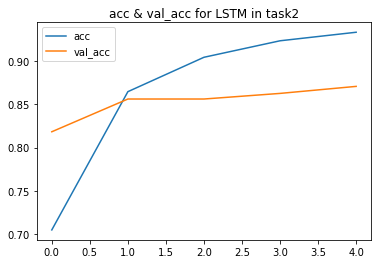

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("acc & val_acc for LSTM in task2")
plt.legend()
plt.show()

It can be seen that the lstm classifier has an accuracy of about 86% at the end. It is possible to see that by epoch 3 the accuracy of the test set is not hinted at. To prevent overfitting, we can let training stop at epoch 3.

In [26]:
print("The mean val_accuracy is:",round(mean(history.history['val_accuracy']),3),'.')

The mean val_accuracy is: 0.853 .


#### Let's see how it works

In [27]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", sentiment_label[1][prediction])


test_sentence1 = "shake bake reverse (bake shaking), you're going mess. parmesan just won't stick extra gritty. want good chicken, make sure follow prescribed order: 1) shake 2) bake you're going finest chicken known man. shake 'n bake baby! …"
predict_sentiment(test_sentence1)

test_sentence2 = "This is the worst flight experience of my life!nearly expired product like reviewer, received box nearly expired product. consume month ordering good deal, buy elsewhere. …"
predict_sentiment(test_sentence2)

test_sentence3 = "lots okay matcha amazing price matcha comes different grades. make mistake, going pound high-quality matcha dollars. matcha drinking; matcha cooking, baking, adventurously powdering breakfast cereal ice cream with. want stuff used japanese tea ceremony, plan pay minimum dollar gram, want lot decent matcha purposes good price, it. …"
predict_sentiment(test_sentence3)

Predicted label:  negative
Predicted label:  negative
Predicted label:  positive


## Task 3. Review Helpfulness Classification

I assume that the number of people who have read the reviews is greater than 10 and that the reviews that more than 89% of people find useful are "helpful reviews".

In [28]:
df['help']=df.apply(lambda x: 'Helpful' if x[4]>=10 and x[3]/x[4]>=0.89 else 'Unhelpful', axis=1)
df['help'].value_counts()

Helpful      4774
Unhelpful    4470
Name: help, dtype: int64

In [29]:
df.head()

,star,title,review,helpful1,helpful2,word_new,sentiment,help
0,2,The herbs were great...but the cherry tomatoes...,The herb kit that came with my Aerogarden was ...,15,17,herbs great...but cherry tomatoes...not great ...,negative,Unhelpful
1,5,Even more useful than regular parchment paper,I originally bought this just because it was c...,19,19,useful regular parchment paper originally boug...,positive,Helpful
2,2,Shake it before you bake it,"If you do it in reverse (bake before shaking),...",2,13,"shake bake reverse (bake shaking), you're goin...",negative,Unhelpful
3,2,Not what the picture describes,I bought this steak for my father in law for C...,7,14,picture describes bought steak father law chri...,negative,Unhelpful
4,2,What a ripe off - GIVE ME A BREAK,Sorry but I had these noodles and they are no ...,10,34,ripe - break sorry noodles better 10 - 20 cent...,negative,Unhelpful


In [30]:
target=df["help"].values
target=pd.DataFrame(target)[0].factorize()[0]

### Classifiers with Tfidf features

#### Bulid classifiers

Use **train_test_split** to split the train and test set.

In [31]:
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size = 0.2,stratify = target)

I create three separate classifiers as Task2. Then I look at their performance on the training set and the test set respectively, and plot the ROC curves.

---------------------On test set--------------------
              precision    recall  f1-score   support

   Unhelpful       0.80      0.80      0.80       894
     Helpful       0.81      0.82      0.81       955

    accuracy                           0.81      1849
   macro avg       0.81      0.81      0.81      1849
weighted avg       0.81      0.81      0.81      1849

[[711 183]
 [176 779]]
---------------------On train set-------------------
              precision    recall  f1-score   support

   Unhelpful       1.00      1.00      1.00      3576
     Helpful       1.00      1.00      1.00      3819

    accuracy                           1.00      7395
   macro avg       1.00      1.00      1.00      7395
weighted avg       1.00      1.00      1.00      7395

[[3575    1]
 [   7 3812]]
-------------------------ROC-----------------------
AUC: 0.889


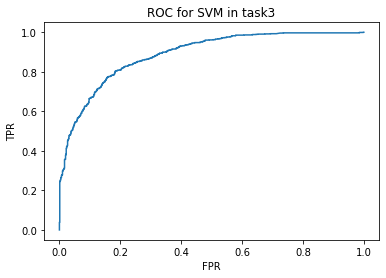

In [32]:
svm_clf = sklearn.svm.LinearSVC()

svm_clf.fit(train_data, train_target)
print("---------------------On test set--------------------")
print(sklearn.metrics.classification_report(test_target, svm_clf.predict(test_data), target_names=['Unhelpful', 'Helpful']))
print(sklearn.metrics.confusion_matrix(test_target, svm_clf.predict(test_data)))
print("---------------------On train set-------------------")
print(sklearn.metrics.classification_report(train_target, svm_clf.predict(train_data), target_names=['Unhelpful', 'Helpful']))
print(sklearn.metrics.confusion_matrix(train_target, svm_clf.predict(train_data)))
print("-------------------------ROC-----------------------")
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(test_target,svm_clf.decision_function(test_data))
print ('AUC:', round(metrics.auc(fpr, tpr),3))
task3_AUC.append(round(metrics.auc(fpr, tpr),3))
plt.title("ROC for SVM in task3")
plt.plot(fpr,tpr,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

---------------------On test set--------------------
              precision    recall  f1-score   support

   Unhelpful       0.79      0.77      0.78       894
     Helpful       0.79      0.81      0.80       955

    accuracy                           0.79      1849
   macro avg       0.79      0.79      0.79      1849
weighted avg       0.79      0.79      0.79      1849

[[687 207]
 [178 777]]
---------------------On train set-------------------
              precision    recall  f1-score   support

   Unhelpful       0.95      0.93      0.94      3576
     Helpful       0.94      0.96      0.95      3819

    accuracy                           0.94      7395
   macro avg       0.95      0.94      0.94      7395
weighted avg       0.94      0.94      0.94      7395

[[3329  247]
 [ 163 3656]]
-------------------------ROC-----------------------
AUC: 0.866


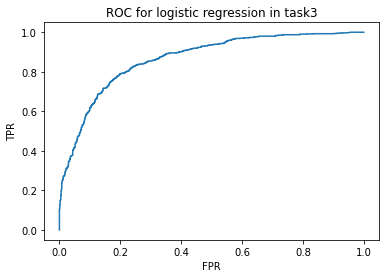

In [33]:
lgre_clf = sklearn.linear_model.LogisticRegression()

lgre_clf.fit(train_data, train_target)
print("---------------------On test set--------------------")
print(sklearn.metrics.classification_report(test_target, lgre_clf.predict(test_data), target_names=['Unhelpful', 'Helpful']))
print(sklearn.metrics.confusion_matrix(test_target, lgre_clf.predict(test_data)))
print("---------------------On train set-------------------")
print(sklearn.metrics.classification_report(train_target, lgre_clf.predict(train_data), target_names=['Unhelpful', 'Helpful']))
print(sklearn.metrics.confusion_matrix(train_target, lgre_clf.predict(train_data)))
print("-------------------------ROC-----------------------")
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(test_target,lgre_clf.decision_function(test_data))
print ('AUC:', round(metrics.auc(fpr, tpr),3))
task3_AUC.append(round(metrics.auc(fpr, tpr),3))
plt.title("ROC for logistic regression in task3")
plt.plot(fpr,tpr,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

---------------------On test set--------------------
              precision    recall  f1-score   support

   Unhelpful       0.88      0.55      0.68       894
     Helpful       0.69      0.93      0.79       955

    accuracy                           0.75      1849
   macro avg       0.78      0.74      0.74      1849
weighted avg       0.78      0.75      0.74      1849

[[495 399]
 [ 69 886]]
---------------------On train set-------------------
              precision    recall  f1-score   support

   Unhelpful       0.99      0.91      0.95      3576
     Helpful       0.92      0.99      0.95      3819

    accuracy                           0.95      7395
   macro avg       0.96      0.95      0.95      7395
weighted avg       0.95      0.95      0.95      7395

[[3239  337]
 [  27 3792]]
-------------------------ROC-----------------------
AUC: 0.87


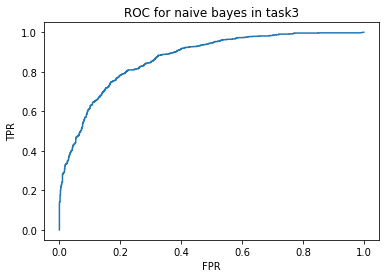

In [34]:
nvb_clf = sklearn.naive_bayes.MultinomialNB()

nvb_clf.fit(train_data, train_target)
print("---------------------On test set--------------------")
print(sklearn.metrics.classification_report(test_target, nvb_clf.predict(test_data), target_names=['Unhelpful', 'Helpful']))
print(sklearn.metrics.confusion_matrix(test_target, nvb_clf.predict(test_data)))
print("---------------------On train set-------------------")
print(sklearn.metrics.classification_report(train_target, nvb_clf.predict(train_data), target_names=['Unhelpful', 'Helpful']))
print(sklearn.metrics.confusion_matrix(train_target, nvb_clf.predict(train_data)))
print("-------------------------ROC-----------------------")
from sklearn.metrics import roc_curve
fpr,tpr, thresholds = roc_curve(test_target,nvb_clf.predict_proba(test_data)[:,1])
print ('AUC:', round(metrics.auc(fpr, tpr),3))
task3_AUC.append(round(metrics.auc(fpr, tpr),3))
plt.title("ROC for naive bayes in task3")
plt.plot(fpr,tpr,label='ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Use **cross_validate** to validate classifiers.

In [35]:
svm_scores = cross_validate(svm_clf, data, target, cv=5,scoring=scoring,return_train_score=True)
svm_time=svm_scores['fit_time'].mean()
svm_test_accuracy=svm_scores['test_accuracy'].mean()
svm_train_accuracy=svm_scores['train_accuracy'].mean()
svm_test_f1=svm_scores['test_f1'].mean()
svm_train_f1=svm_scores['train_f1'].mean()

In [36]:
lgre_scores = cross_validate(lgre_clf, data, target, cv=5,scoring=scoring,return_train_score=True)
lgre_time=lgre_scores['fit_time'].mean()
lgre_test_accuracy=lgre_scores['test_accuracy'].mean()
lgre_train_accuracy=lgre_scores['train_accuracy'].mean()
lgre_test_f1=lgre_scores['test_f1'].mean()
lgre_train_f1=lgre_scores['train_f1'].mean()

In [37]:
nvb_scores = cross_validate(nvb_clf, data, target, cv=5,scoring=scoring,return_train_score=True)
nvb_time=nvb_scores['fit_time'].mean()
nvb_test_accuracy=nvb_scores['test_accuracy'].mean()
nvb_train_accuracy=nvb_scores['train_accuracy'].mean()
nvb_test_f1=nvb_scores['test_f1'].mean()
nvb_train_f1=nvb_scores['train_f1'].mean()

#### Visualisation of classification results

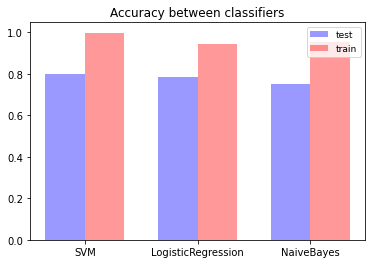

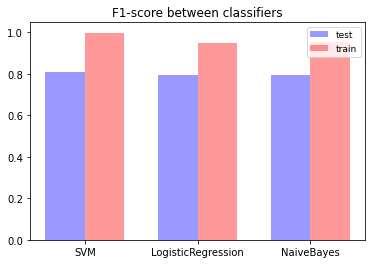

In [38]:
index = np.arange(3)
bar_width = 0.35
y1 = [svm_test_accuracy, lgre_test_accuracy, nvb_test_accuracy]
y2 =[svm_train_accuracy, lgre_train_accuracy, nvb_train_accuracy]
plt.bar(index, y1, bar_width,
                alpha=0.4, color='b',label='test')
plt.bar(index+bar_width, y2, bar_width,
                alpha=0.4, color='r',label='train')
x_labels = ['SVM', 'LogisticRegression', 'NaiveBayes']
plt.xticks(index+bar_width/2, x_labels) 
plt.title("Accuracy between classifiers")
plt.legend(prop={"size": 9})
plt.show()

index = np.arange(3)
bar_width = 0.35
y1 = [svm_test_f1, lgre_test_f1, nvb_test_f1]
y2 =[svm_train_f1, lgre_train_f1, nvb_train_f1]
plt.bar(index, y1, bar_width,
                alpha=0.4, color='b',label='test')
plt.bar(index+bar_width, y2, bar_width,
                alpha=0.4, color='r',label='train')
x_labels = ['SVM', 'LogisticRegression', 'NaiveBayes']
plt.xticks(index+bar_width/2, x_labels) 
plt.title("F1-score between classifiers")
plt.legend(prop={"size": 9})
plt.show()

### LSTM classifier

Use the **factorize()** method to convert categorical values to numerical values.

In [39]:
help_label = df.help.factorize()
word_new = df.word_new.values

With the help of the tokeniser, all words in the text are tokenised. During tokenisation, we break down all words/sentences in the text into small parts called tokens.

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(word_new)
vocab_size = len(tokenizer.word_index) + 1

Use the **text_to_sequence()** method to replace the word with its specified number.

In [41]:
word_seq = tokenizer.texts_to_sequences(word_new)

let all sentences have the same length.

In [42]:
word_pad = pad_sequences(word_seq, maxlen=200)

Build LSTM.

In [43]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [44]:
history = model.fit(word_pad,help_label[0],validation_split=0.2, epochs=8, batch_size=32)

Epoch 1/8
232/232 [==============================] - 26s 105ms/step - loss: 0.6291 - accuracy: 0.6349 - val_loss: 0.5462 - val_accuracy: 0.7361
Epoch 2/8
232/232 [==============================] - 24s 105ms/step - loss: 0.4817 - accuracy: 0.7761 - val_loss: 0.5205 - val_accuracy: 0.7534
Epoch 3/8
232/232 [==============================] - 25s 106ms/step - loss: 0.4094 - accuracy: 0.8266 - val_loss: 0.5249 - val_accuracy: 0.7691
Epoch 4/8
232/232 [==============================] - 25s 108ms/step - loss: 0.3610 - accuracy: 0.8488 - val_loss: 0.5460 - val_accuracy: 0.7610
Epoch 5/8
232/232 [==============================] - 25s 106ms/step - loss: 0.3268 - accuracy: 0.8698 - val_loss: 0.5838 - val_accuracy: 0.7626
Epoch 6/8
232/232 [==============================] - 25s 107ms/step - loss: 0.2967 - accuracy: 0.8822 - val_loss: 0.5949 - val_accuracy: 0.7658
Epoch 7/8
232/232 [==============================] - 28s 121ms/step - loss: 0.2741 - accuracy: 0.8905 - val_loss: 0.5837 - val_accuracy:

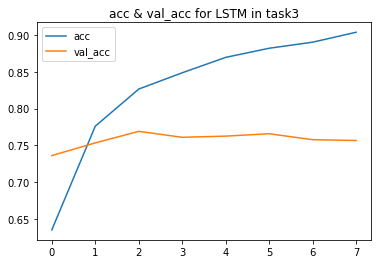

In [45]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title("acc & val_acc for LSTM in task3")
plt.legend()
plt.show()

In [46]:
print("The mean val_accuracy of last 3 epoch is:",round(mean(history.history['val_accuracy'][-3:]),3),'.')

The mean val_accuracy of last 3 epoch is: 0.76 .


### Differences between the results from Tasks 2&3

Let's look at the AUC of the different classifiers in TASK2 and TASK3.

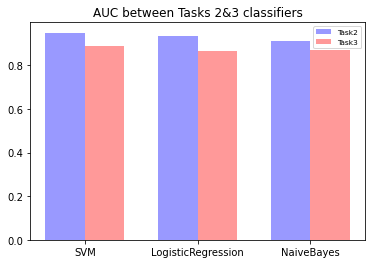

In [47]:
index = np.arange(3)
bar_width = 0.35
 
plt.bar(index, task2_AUC, bar_width,
                alpha=0.4, color='b',label='Task2')
plt.bar(index+bar_width, task3_AUC, bar_width,
                alpha=0.4, color='r',label='Task3')
x_labels = ['SVM', 'LogisticRegression', 'NaiveBayes']
plt.xticks(index+bar_width/2, x_labels) 
plt.title("AUC between Tasks 2&3 classifiers")
plt.legend(prop={"size": 7.5})
plt.show()

Each classifier performed better on task2 than task3 and get a higher AUC. I guess the reason is that the number of stars is a good indicator of the evaluator's emotion, and the content of the text basically reflects the number of stars; however, it is difficult to deduce whether the evaluation is useful or not based on the content of the text. The usefulness data is highly dependent on the recommendation system of the page, computers do not know what reviews are useful, so useful reviews are not necessarily recommended and will not necessarily be seen by others. And many users do not necessarily click on the "helpful" button on the page after viewing the comments, so this makes the predictions less accurate.

So in task3, I was able to find that some of my classifiers made a lot of type I errors. And task3's accuracy and f1-score are not as high as task2.

## Conclusion

I used four different classifiers to classify and evaluate the text information for this task: SVM classifier, Naive Bayes classifier, Logistic Regression classifier, and LSTM classifier. In terms of classification results, the SVM classifier was the best classifier for this problem, with a fast classification speed and high classification accuracy.  